# Investigation Four Univariate Streaming State Assignment

The dataset in this application is from a flow rate transmitter on an industrial cooling water flow measured in kg/s. 

The data is read on a two second interval, and indexed $0,.., n$ as required by __trcrpm__.

The investigation is to determine whether __trcrpm__ state assignment signal may be useful for identifying signal anomalies in a quasi real time batch updating fashion. 

This code is based on the trcrpm tutorials. It is included to demonstrate the basic functionality of the code base, as well as to highlight intuitively, the trcrpm algorithm.

In [3]:
# the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
from trcrpm import TRCRP_Mixture
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import MISSING_RENDERERS
from bokeh.layouts import column
from IPython.core.display import display, HTML

In [4]:
# indicates to jupyer how the plots are to be displayed and sized and some other
# housekeeping particular to this notebook
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
silence(MISSING_RENDERERS, True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [5]:
# Read the data and fast forward to a convenient spot
data = pd.read_csv("../data/anomaly0245.csv", index_col=0)
#data = data.iloc[156600:240000].reset_index(drop=True)

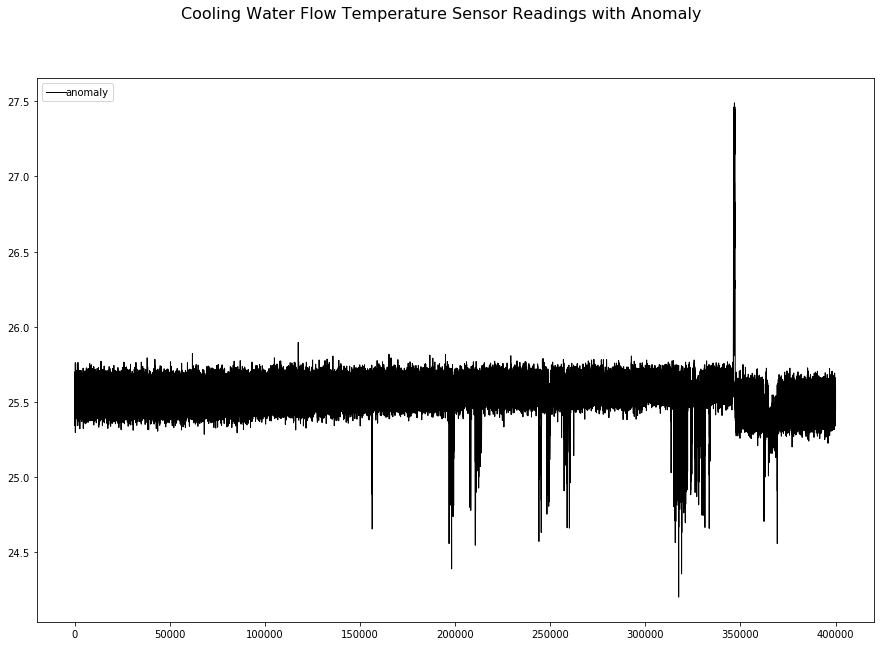

In [6]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Cooling Water Flow Temperature Sensor Readings with Anomaly', fontsize=16)
index = list(data.columns).index(data.columns[0])
x_observed = data.index
y_observed = data.loc[:,data.columns[0]]
axes.plot(x_observed, y_observed, label=data.columns[0], color='k', linewidth=1)
axes.legend(loc='upper left', handletextpad=0)

In [ ]:
# Setup the bokeh plots and call backs
output_notebook()                
p1 = figure(title=data.columns[0], plot_height=250, plot_width=800)
p1.yaxis.axis_label = 'Temperature Celsius'

p2 = figure(title="CRP States", plot_height=250, plot_width=800, x_range=p1.x_range)
p2.yaxis.axis_label= "States"

p3 = figure(title="Cascaded CRP States", plot_height=250, plot_width=800, x_range=p1.x_range)
p3.yaxis.axis_label= "States"
p3.xaxis.axis_label = 'Datapoint'

p = column(p1, p2, p3)
target = show(p, notebook_handle=True)

# Setup the placekeeping and initilizing variables
chain = 0
x, eng_val, states, num_states = [], [], [], []
i = 0
step = 900
print(i)

rng = np.random.RandomState(1)
model = TRCRP_Mixture(chains=1, lag=4, variables=data.columns, rng=rng)
model.incorporate(data[i:i + step])
model.resample_all(steps=10)
model.resample_hyperparameters(steps=10)
s = model.get_temporal_regimes('anomaly')[chain]
num_states = step * [len(sorted(set(s)))]
states = list(s[i:i + step])
eng_val = data.iloc[i:i + step, 0].tolist()
x = list(range(i, i + step ))

data2 = pd.DataFrame({'anomaly': s[:]})
model2 = TRCRP_Mixture(chains=1, lag=4, variables=data2.columns, rng=rng)
model2.incorporate(data2)
model2.resample_all(steps=10)
model2.resample_hyperparameters(steps=10)
s2 = model2.get_temporal_regimes('anomaly')[chain]
num_states2 = step * [len(sorted(set(s2)))]
states2 = list(s2[i:i + step])
eng_val2 = data.iloc[i:i + step, 0].tolist()
x2 = list(data2.index)


for i in range(step, len(data) - step, step):
    print(i)
    # Setup the bokeh plots and render via call back
    line1 = p1.line(x = x,
                   y = eng_val,
                   color='blue',
                   name='g1',
                   line_width=1, 
                   legend_label="Signal 01")

    line2 = p2.line(x = x,
                   y = num_states,
                   color='red',
                   name='g2',
                   line_width=1,
                   legend_label="# States in Batch")

    line3 = p2.line(x = x,
                   y = states,
                   color='green',
                   name='g3',
                   line_width=1,
                   legend_label="Datapoint State")
    
    line4 = p3.line(x = x,
                   y = num_states2,
                   color='red',
                   name='g2',
                   line_width=1,
                   legend_label="# States in Batch")

    line5 = p3.line(x = x,
                   y = states2,
                   color='green',
                   name='g3',
                   line_width=1,
                   legend_label="Datapoint State")
    

    push_notebook(handle=target)
    model.incorporate(data[i:i + step])
    start = time.time()
    model.resample_all(steps=10)
    end = time.time()
    start = time.time()
    model.resample_hyperparameters(steps=10)
    end = time.time()
    s = model.get_temporal_regimes("anomaly")[chain]
    num_states = step * [len(sorted(set(s)))]
    states = list(s[i:i + step])
    eng_val = data.iloc[i:i + step, 0].tolist()
    x = list(range(i, i + step ))
    data2 = pd.DataFrame({'anomaly': s[:]})
    model2.incorporate(data2)
    model2.resample_all(steps=10)
    model2.resample_hyperparameters(steps=10)
    s2 = model2.get_temporal_regimes('anomaly')[chain]
    num_states2 = step * [len(sorted(set(s2)))]
    states2 = list(s2[i:i + step])
    eng_val2 = data.iloc[i:i + step, 0].tolist()
    x2 = list(data2.index)

Loading BokehJS ...

0
Completed: 10 iterations in 0.509900 seconds.
Completed: 10 iterations in 1.787577 seconds.
Completed: 10 iterations in 0.270637 seconds.
Completed: 10 iterations in 0.712970 seconds.
900
Completed: 10 iterations in 0.722913 seconds.
Completed: 10 iterations in 1.627971 seconds.
Completed: 10 iterations in 0.478049 seconds.
Completed: 10 iterations in 0.594558 seconds.
1800
Completed: 10 iterations in 1.060175 seconds.
Completed: 10 iterations in 2.724690 seconds.
Completed: 10 iterations in 0.774424 seconds.
Completed: 10 iterations in 1.226118 seconds.
2700
Completed: 10 iterations in 1.072208 seconds.
Completed: 10 iterations in 1.545784 seconds.
Completed: 10 iterations in 0.954980 seconds.
Completed: 10 iterations in 0.898097 seconds.
3600
Completed: 10 iterations in 1.621293 seconds.
Completed: 10 iterations in 2.211113 seconds.
Completed: 10 iterations in 1.667138 seconds.
Completed: 10 iterations in 2.550261 seconds.
4500
Completed: 10 iterations in 1.964789 seconds.
Complete

In [ ]:
probes = model.dataset.index
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

In [ ]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [ ]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    #ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples, 'anomaly', axes)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples_chain, 'anomaly', axes, states_from_chain=chain)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

In [ ]:
fig, axes = plt.subplots(nrows=1)
plot_predictions(samples, 'anomaly', axes)
axes.set_xlim([min(probes), max(probes)])
fig.set_size_inches(20,10)

In [ ]:
%qtconsole